# PREPARE DATA

In [113]:
# Import libraries
import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt


def is_time_between(start_hour, end_hour, check_hour):
    if start_hour < end_hour:
        return start_hour <= check_hour <= end_hour
    else:  # crosses midnight
        return check_hour >= start_hour or check_hour <= end_hour
    
def is_time_between_exc(start_hour, end_hour, check_hour):
    if start_hour < end_hour:
        return start_hour >= check_hour < end_hour
    else:  # crosses midnight
        return check_hour >= start_hour or check_hour < end_hour

dataset_name = "GBP_USD_H1"
# Read the ohlcv data
# oanda_path = "/projects/genomic-ml/da2343/ml_project_2/data/gen_oanda_data"
oanda_path = "/Users/newuser/Projects/robust_algo_trader/data/gen_oanda_data"
df = pd.read_csv(f'{oanda_path}/{dataset_name}_processed_data.csv')
df = df.rename(columns={"time": "Time"})
df["Index"] = df.index
y = df[["Close"]]
offset = y.index[0]
df["Time"] = pd.to_datetime(df["Time"])
df['EMA_100'] = ta.EMA(df['Close'], timeperiod=100)
# drop na values
df = df.dropna()
# filter when time is only in 2016
df = df[df["Time"] >= "2020-01-01 00:00:00"]
df

,Time,Open,High,Low,Close,Volume,SMA_20,SMA_30,SMA_50,SMA_100,...,WILLR,BBANDS_Upper,BBANDS_Middle,BBANDS_Lower,AD,ADOSC,VOLUME_RSI,MFI,Index,EMA_100
96387,2020-01-01 22:00:00+00:00,1.32607,1.32607,1.32476,1.32514,980,1.319731,1.317050,1.314763,1.308065,...,-21.667761,1.326384,1.324996,1.323608,-9.349236e+05,762.732526,51.259074,86.363286,96387,1.310985
96388,2020-01-01 23:00:00+00:00,1.32509,1.32618,1.32491,1.32502,235,1.320348,1.317488,1.315092,1.308357,...,-25.579656,1.326327,1.324956,1.323585,-9.351179e+05,515.185672,43.982911,85.430763,96388,1.311263
96389,2020-01-02 00:00:00+00:00,1.32506,1.32622,1.32474,1.32566,524,1.321028,1.317942,1.315448,1.308678,...,-24.131944,1.326323,1.325292,1.324261,-9.349905e+05,407.636725,47.118790,84.350842,96389,1.311548
96390,2020-01-02 01:00:00+00:00,1.32570,1.32666,1.32537,1.32560,564,1.321726,1.318409,1.315780,1.308990,...,-29.831933,1.326249,1.325496,1.324743,-9.353533e+05,211.118543,47.556391,82.262557,96390,1.311827
96391,2020-01-02 02:00:00+00:00,1.32564,1.32564,1.32441,1.32486,375,1.322394,1.318893,1.316083,1.309266,...,-38.786566,1.325893,1.325256,1.324619,-9.354540e+05,79.519951,45.634807,77.338907,96391,1.312085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121188,2023-12-22 17:00:00+00:00,1.27198,1.27218,1.26981,1.27093,5752,1.270152,1.269210,1.267250,1.267971,...,-55.537975,1.274148,1.272218,1.270288,-1.557736e+06,940.903857,49.709643,44.500011,121188,1.268034
121189,2023-12-22 18:00:00+00:00,1.27092,1.27104,1.27020,1.27036,3868,1.270251,1.269365,1.267340,1.268007,...,-64.556962,1.273445,1.271582,1.269719,-1.560130e+06,-165.276088,45.486458,40.915316,121189,1.268080
121190,2023-12-22 19:00:00+00:00,1.27034,1.27034,1.26902,1.27030,6042,1.270351,1.269438,1.267406,1.268066,...,-66.134185,1.272321,1.271022,1.269723,-1.554454e+06,1203.163001,50.692154,39.935639,121190,1.268124
121191,2023-12-22 20:00:00+00:00,1.27031,1.27054,1.26961,1.27030,3807,1.270418,1.269553,1.267484,1.268138,...,-66.134185,1.272013,1.270762,1.269511,-1.552612e+06,2239.722238,45.845179,40.573136,121191,1.268167


## STRATEGY ADAPTIVE PROFIT

In [ ]:
# Initialize the variables for position, entry price and stop loss
position = 0
entry_price = 0
stop_loss = 0
trades = []

for i, row in df.iterrows():
    current_time = row["Time"]
    condition_one = (
            (row["MACD_Crossover_Change"] > 0)
            and (row["Close"] > row["EMA_100"])
            and is_time_between(start_hour, end_hour, current_time.hour)
    )
    condition_two = (
            (row["MACD_Crossover_Change"] < 0)
            and (row["Close"] < row["EMA_100"])
            and is_time_between(start_hour, end_hour, current_time.hour)
    )
    if position == 0:
        if condition_one:
            position = 1
            entry_price = row['Close']
            stop_loss = entry_price - atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Buy', current_time, entry_price, 0])
        elif condition_two:
            position = -1 
            entry_price = row['Close']
            stop_loss = entry_price + atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Sell', current_time, entry_price, 0])
    elif position == 1:
        if row['Low'] < stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', current_time, exit_price, risk_reward]
        else:
            stop_loss = max(stop_loss,  row['Close'] - atr_delta*row['ATR'])
    elif position == -1:
        if row['High'] > stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', current_time, exit_price, risk_reward]
        else:
            stop_loss = min(stop_loss, row['Close'] + atr_delta*row['ATR'])

# Convert the list of trades to a dataframe
trades_df = pd.DataFrame(trades, columns=['Action', 'Time', 'Price', 'PnL'])

# Print the trades
# Add the PnL_label column where 1 is a positive or breakeven return and 0 is a negative return
trades_df['PnL_label'] = np.where(trades_df['PnL'] >= 0, 1, 0)
trades_df

In [ ]:
trades_df['Time'] = pd.to_datetime(trades_df['Time'])
trades_df['Year'] = trades_df['Time'].dt.year
trades_df['Month'] = trades_df['Time'].dt.month
sub_trades_df = trades_df[trades_df['Year'] == 2016].copy()
sub_trades_df = sub_trades_df[['Month', f'PnL']]
sub_trades_df = sub_trades_df.groupby(['Month']).agg({f'PnL': 'sum'}).reset_index()

# using the label column find the cumulative sum
sub_trades_df["cumulative_sum"] = sub_trades_df["PnL"].cumsum()
#plot first 100 trades
sub_trades_df["cumulative_sum"].plot()
# sub_trades_df

In [ ]:
# EUR_USD_H1 : off-years = 2014, 2016, 2021
# EUR_JPY_H1 : off-years = 2016
# GBP_JPY_H1 : off-years = 2023
# USD_MXN_H1 : off-years = 2018, 2019, 2022
# NZD_JPY_H1 : off-years = 2014, 2015, 2019

# AUD_HKD_H1 : off-years = 2015, 2018, 2019, 2021
# EUR_GBP_H1 : off-years = 2018, 2021, 2022, 2023

# ZAR_JPY_H1 : off-years = 2014, 2015, 2017, 2019
# USD_NOK_H1 : off-years = 2014, 2015
# USD_CHF_H1 : off-years = 2014
# TRY_JPY_H1 : off-years = 2014, 2019, 2021, 2022, 2023
# AUD_USD_H1 : off-years = 2015,2016,2018, 2019, 2022

In [ ]:
trades_df["PnL_label"].mean()

## STRATEGY FIXED PROFIT AND LOSS

In [ ]:
# Initialize the variables for position, entry price and stop loss
position = 0
entry_price = 0
stop_loss = 0
trades = []
atr_delta = 1.5
start_hour = 13
end_hour = 17

for i, row in df.iterrows():
    current_time = row["Time"]
    condition_buy = (
            (row["MACD_Crossover_Change"] > 0)
            and (row["Close"] > row["EMA_100"])
            and is_time_between(start_hour, end_hour, current_time.hour)
    )
    condition_sell = (
            (row["MACD_Crossover_Change"] < 0)
            and (row["Close"] < row["EMA_100"])
            and is_time_between(start_hour, end_hour, current_time.hour)
    )
    if position == 0:
        if condition_buy:
            position = 1
            entry_price = row['Close']
            stop_loss = entry_price - atr_delta*row['ATR']
            take_profit = entry_price + atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Buy', current_time, entry_price, 0])
        elif condition_sell:
            position = -1 
            entry_price = row['Close']
            stop_loss = entry_price + atr_delta*row['ATR']
            take_profit = entry_price - atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Sell', current_time, entry_price, 0])
    elif position == 1:
        if row['Low'] < stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', current_time, exit_price, risk_reward]
        elif row['High'] > take_profit:
            position = 0
            exit_price = take_profit
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', current_time, exit_price, risk_reward]
        else:
            pass
    elif position == -1:
        if row['High'] > stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', current_time, exit_price, risk_reward]
        elif row['Low'] < take_profit:
            position = 0
            exit_price = take_profit
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', current_time, exit_price, risk_reward]    
        else:
            pass

# Convert the list of trades to a dataframe
trades_df = pd.DataFrame(trades, columns=['Action', 'Time', 'Price', 'PnL'])

# Print the trades
# Add the PnL_label column where 1 is a positive or breakeven return and 0 is a negative return
trades_df['PnL_label'] = np.where(trades_df['PnL'] >= 0, 1, 0)
trades_df

In [ ]:
trades_df['Time'] = pd.to_datetime(trades_df['Time'])
trades_df['Year'] = trades_df['Time'].dt.year
trades_df['Month'] = trades_df['Time'].dt.month
sub_trades_df = trades_df[trades_df['Year'] == 2016].copy()
sub_trades_df = sub_trades_df[['Month', f'PnL']]
sub_trades_df = sub_trades_df.groupby(['Month']).agg({f'PnL': 'sum'}).reset_index()

# using the label column find the cumulative sum
sub_trades_df["cumulative_sum"] = sub_trades_df["PnL"].cumsum()
#plot first 100 trades
sub_trades_df["cumulative_sum"].plot()
# sub_trades_df

In [ ]:
# AUD_HKD_H1 : off-years = 2015, 2018
# EUR_GBP_H1: 2018, 2019, 2021


## STRATEGY FIXED PROFIT AND ADAPTIVE LOSS

In [ ]:
# Initialize the variables for position, entry price and stop loss
position = 0
entry_price = 0
stop_loss = 0
trades = []

for i, row in df.iterrows():
    current_time = row["Time"]
    condition_buy = (
            (row["MACD_Crossover_Change"] > 0)
            and (row["Close"] > row["EMA_100"])
            and is_time_between(start_hour, end_hour, current_time.hour)
    )
    condition_sell = (
            (row["MACD_Crossover_Change"] < 0)
            and (row["Close"] < row["EMA_100"])
            and is_time_between(start_hour, end_hour, current_time.hour)
    )
    if position == 0:
        if condition_buy:
            position = 1
            entry_price = row['Close']
            stop_loss = entry_price - atr_delta*row['ATR']
            take_profit = entry_price + atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Buy', current_time, entry_price, 0])
        elif condition_sell:
            position = -1 
            entry_price = row['Close']
            stop_loss = entry_price + atr_delta*row['ATR']
            take_profit = entry_price - atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Sell', current_time, entry_price, 0])
    elif position == 1:
        if row['Low'] < stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', current_time, exit_price, risk_reward, take_profit, stop_loss]
        elif row['High'] > take_profit:
            position = 0
            exit_price = take_profit
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', current_time, exit_price, risk_reward, take_profit, stop_loss]
        else:
            # stop loss must not be greater than the take profit
            # pass
            next_stop_loss = row['Close'] - atr_delta*row['ATR']
            if next_stop_loss < take_profit:
                stop_loss = max(stop_loss, next_stop_loss)
    elif position == -1:
        if row['High'] > stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', current_time, exit_price, risk_reward, take_profit, stop_loss]
        elif row['Low'] < take_profit:
            position = 0
            exit_price = take_profit
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', current_time, exit_price, risk_reward, take_profit, stop_loss] 
        else:
            # pass
            next_stop_loss = row['Close'] + atr_delta*row['ATR']
            if next_stop_loss > take_profit:
                stop_loss = min(stop_loss, next_stop_loss)

# Convert the list of trades to a dataframe
trades_df = pd.DataFrame(trades, columns=['Action', 'Time', 'Price', 'PnL', 'Take_Profit', 'Stop_Loss'])

# Print the trades
# Add the PnL_label column where 1 is a positive or breakeven return and 0 is a negative return
trades_df['PnL_label'] = np.where(trades_df['PnL'] >= 0, 1, 0)
trades_df

In [ ]:
trades_df["cumulative_sum"] = trades_df["PnL"].cumsum()
trades_df["cumulative_sum"].plot()

In [ ]:
trades_df['Time'] = pd.to_datetime(trades_df['Time'])
trades_df['Year'] = trades_df['Time'].dt.year
trades_df['Month'] = trades_df['Time'].dt.month
sub_trades_df = trades_df[trades_df['Year'] == 2014].copy()
sub_trades_df = sub_trades_df[['Month', f'PnL']]
sub_trades_df = sub_trades_df.groupby(['Month']).agg({f'PnL': 'sum'}).reset_index()
sub_trades_df["cumulative_sum"] = sub_trades_df["PnL"].cumsum()
sub_trades_df["cumulative_sum"].plot()

In [ ]:
x = 642
y = 599

p = (x) / (x+y)
p * 100

In [ ]:
df

## OPENING RANGE BREAKOUT STRATEGY

In [122]:
# Initialize the variables for position, entry price and stop loss
position = 0
entry_price = 0
stop_loss = 0
trades = []


atr_delta = 2
start_hour = 8
end_hour = 17
range_start_hour = 5

for i, row in df.iterrows():
    current_time = row["Time"]
    latest_trade_date = trades[-1][1].date() if trades else None
    current_date = current_time.date()

    if (
        position == 0
        and is_time_between_exc(start_hour, end_hour, current_time.hour)
        and current_date != latest_trade_date
    ):
        # range_df should be from range_start_hour to range_end_hour
        range_df = df[
            (df["Time"].dt.hour >= range_start_hour)
            & (df["Time"].dt.hour < start_hour)
            & (df["Time"].dt.date == current_date)
        ]

        if range_df.empty:
            continue

        opening_high = range_df["High"].max()
        opening_low = range_df["Low"].min()
        opening_range = opening_high - opening_low
        
        if opening_range < row["ATR"]:
            continue

        condition_buy = (row["Close"] < opening_high)
        condition_sell = (row["Close"] > opening_low)

        if condition_buy:
            position = 1
            entry_price = row['Close']
            # stop_loss = entry_price - atr_delta*row['ATR']
            # take_profit = entry_price + atr_delta*row['ATR']

            take_profit = entry_price + opening_range
            stop_loss = entry_price - opening_range
            init_stop_loss = stop_loss
            trades.append(['Buy', current_time, entry_price, 0])
        elif condition_sell:
            position = -1 
            entry_price = row['Close']
            stop_loss = entry_price + atr_delta*row['ATR']
            take_profit = entry_price - atr_delta*row['ATR']
            
            take_profit = entry_price - opening_range
            stop_loss = entry_price + opening_range
            init_stop_loss = stop_loss
            trades.append(['Sell', current_time, entry_price, 0])
    elif position == 1:
        if row['Low'] < stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', current_time, exit_price, risk_reward]
        elif row['High'] > take_profit:
            position = 0
            exit_price = take_profit
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', current_time, exit_price, risk_reward]
        else:
            pass
    elif position == -1:
        if row['High'] > stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', current_time, exit_price, risk_reward]
        elif row['Low'] < take_profit:
            position = 0
            exit_price = take_profit
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', current_time, exit_price, risk_reward]    
        else:
            pass


In [123]:
# Convert the list of trades to a dataframe
trades_df = pd.DataFrame(trades, columns=['Action', 'Time', 'Price', 'PnL'])

# Print the trades
# Add the PnL_label column where 1 is a positive or breakeven return and 0 is a negative return
trades_df['PnL_label'] = np.where(trades_df['PnL'] >= 0, 1, 0)
trades_df["PnL_label"].mean() 

0.6530398322851153

In [124]:
trades_df

,Action,Time,Price,PnL,PnL_label
0,Sell,2020-01-02 03:00:00+00:00,1.32292,1.0,1
1,Sell,2020-01-03 06:00:00+00:00,1.31092,1.0,1
2,Buy,2020-01-06 08:00:00+00:00,1.31057,1.0,1
3,Sell,2020-01-07 07:00:00+00:00,1.31415,1.0,1
4,Buy,2020-01-08 07:00:00+00:00,1.31580,1.0,1
...,...,...,...,...,...
949,Buy,2023-12-18 09:00:00+00:00,1.26751,-1.0,0
950,Buy,2023-12-19 08:00:00+00:00,1.26804,1.0,1
951,Buy,2023-12-20 12:00:00+00:00,1.26469,-1.0,0
952,Buy,2023-12-21 08:00:00+00:00,1.26261,-1.0,0


<Axes: >

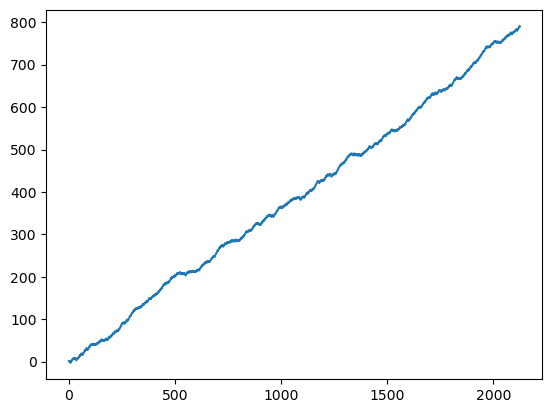

In [105]:
trades_df["cumulative_sum"] = trades_df["PnL"].cumsum()
trades_df["cumulative_sum"].plot()

In [ ]:
trades_df